<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/john210808/covasim_delta/blob/main/demo/test/CalibrateTest.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>

In [ ]:
pip install covasim optuna

In [1]:
import pandas as pd
from datetime import datetime
import covasim as cv

pd.read_csv("https://raw.githubusercontent.com/M3IT/COVID-19_Data/master/Data/COVID_AU_state.csv").to_csv("COVID_AU_state.csv")

def processDate(start_date):
    df = pd.read_csv("COVID_AU_state.csv")
    df['date'] = pd.to_datetime(df['date'])  
    mask = (df.date >= pd.to_datetime(start_date)) & (df.state_abbrev == 'NSW')
    df = df.loc[mask]
    initCase = df['confirmed_cum'].values[0]
    df = df[['date', 'confirmed', 'tests', 'deaths']]
    df.columns = ['date', 'new_diagnoses', 'new_tests', 'new_deaths']
    df.to_csv("nsw.csv", index=False)
    return initCase
processDate('2021-06-01')

Covasim 3.0.7 (2021-06-29) — © 2021 by IDM


5587

### refer to:  https://github.com/Jasminapg/Covid-19-Analysis

In [27]:
import optuna as op

# refer to: http://www.healthstats.nsw.gov.au/indicator/dem_pop_age
nsw = {
   '0-9':  1057247,
  '10-19': 965844,
  '20-29': 1057444,
  '30-39': 1179944,
  '40-49': 1061300,
  '50-59': 999078,
  '60-69': 877865,
  '70-79': 617866,
  '80+':   369288
}

cv.data.country_age_data.data['NSW'] = nsw


def create_sim(x):

#     beta = x[0]
#     pop_infected = x[1]
#     s_prob_may = x[2]
#     s_prob_june = x[3]

    start_day = '2021-06-15'
    end_day   = '2021-09-15'
    data_path = 'nsw.csv'


    pars = dict(
        location = 'NSW',
        pop_type  = 'hybrid',
        pop_size  = 81.85e3, # 8.185M people
        pop_scale = 100,
        pop_infected = 50,
        rescale   = True,
        rescale_threshold = 0.05,
        rescale_factor = 2,
        start_day = start_day,
        end_day   = end_day,
        contacts  = {'h':3.0, 's':20, 'w':20, 'c':20},
        # beta      =  0.023,
        beta_layer  = dict(h=3.0, s=0.6, w=0.6, c=0.3)
    )

    # Create the baseline simulation
    sim = cv.Sim(pars=pars, datafile=data_path)

    # Define testing interventions -- 97% sensitivity from https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7177629/
    test_kwargs = dict(daily_tests=sim.data['new_tests'], test_delay=2, sensitivity=0.97)
    tn = cv.test_num(start_day='2021-06-15', end_day=None, **test_kwargs, label='tn')
    interventions = [tn]

    # https://education.nsw.gov.au/public-schools/going-to-a-public-school/calendars
    school_days = ['2021-06-25', '2021-07-12', '2021-09-17'] # school events
    holidays = ['2021-06-14'] # Queen's Birthday
    weekends = [] # weekends

    sim.update_pars(interventions=interventions)
    for intervention in sim['interventions']:
        intervention.do_plot = False

    return sim


In [28]:
# Create and run the sim
sim = create_sim(None)
sim.run()
fit = sim.compute_fit()
print(fit.mismatch)

  Automatically adding cumulative column cum_diagnoses from new_diagnoses
  Automatically adding cumulative column cum_tests from new_tests
  Automatically adding cumulative column cum_deaths from new_deaths
Initializing sim with 81850 people for 92 days
Loading location-specific data for "NSW"
  Running 2021-06-15 ( 0/92) (3.08 s)  ———————————————————— 1%
  Running 2021-06-25 (10/92) (3.23 s)  ••—————————————————— 12%
  Running 2021-07-05 (20/92) (3.41 s)  ••••———————————————— 23%
  Running 2021-07-15 (30/92) (3.60 s)  ••••••—————————————— 33%
  Running 2021-07-25 (40/92) (3.85 s)  ••••••••———————————— 44%
  Running 2021-08-04 (50/92) (4.11 s)  ••••••••••—————————— 55%
  Running 2021-08-14 (60/92) (4.37 s)  •••••••••••••——————— 66%
  Running 2021-08-24 (70/92) (4.63 s)  •••••••••••••••————— 76%
  Running 2021-09-03 (80/92) (4.87 s)  •••••••••••••••••——— 87%
  Running 2021-09-13 (90/92) (5.26 s)  •••••••••••••••••••— 98%
Simulation summary:
   3578349 cumulative infections
       0 cum

  Automatically adding cumulative column cum_diagnoses from new_diagnoses
  Automatically adding cumulative column cum_tests from new_tests
  Automatically adding cumulative column cum_deaths from new_deaths
Initializing sim with 81850 people for 76 days
Loading location-specific data for "NSW"
  Running 2021-06-15 ( 0/76) (2.73 s)  ———————————————————— 1%
  Running 2021-06-25 (10/76) (2.86 s)  ••—————————————————— 14%
  Running 2021-07-05 (20/76) (3.03 s)  •••••——————————————— 27%
  Running 2021-07-15 (30/76) (3.21 s)  ••••••••———————————— 40%
  Running 2021-07-25 (40/76) (3.46 s)  ••••••••••—————————— 53%
  Running 2021-08-04 (50/76) (3.73 s)  •••••••••••••——————— 66%
  Running 2021-08-14 (60/76) (3.98 s)  •••••••••••••••————— 79%
  Running 2021-08-24 (70/76) (4.24 s)  ••••••••••••••••••—— 92%
Simulation summary:
   630249 cumulative infections
       0 cumulative reinfections
   359085 cumulative infectious
   216984 cumulative symptomatic cases
    9419 cumulative severe cases
    

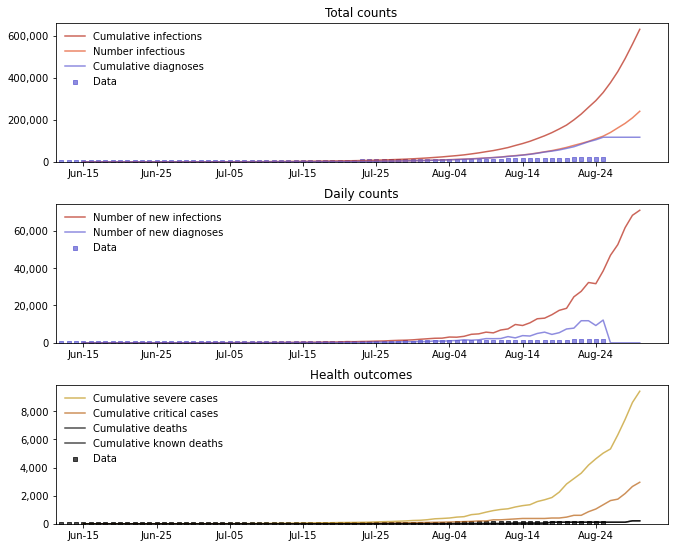

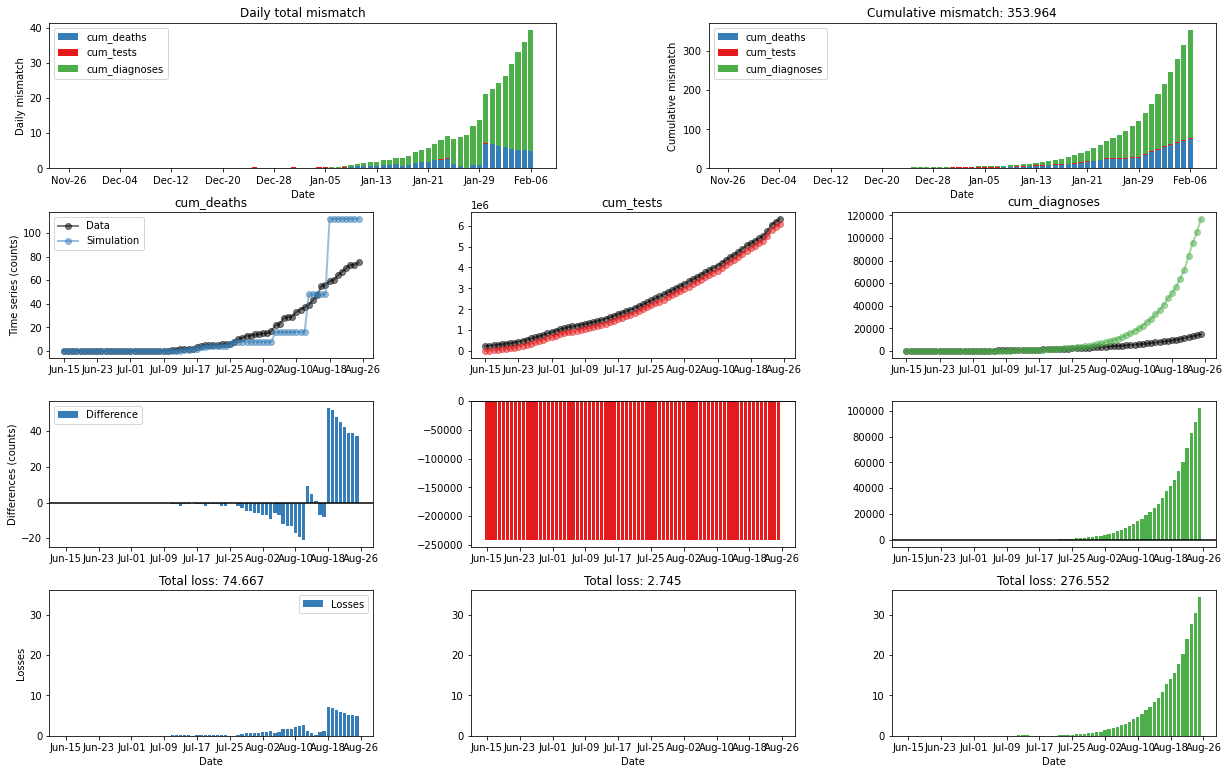

#0. cum_deaths:    74.66666666666667
#1. cum_tests:     2.745103469543837
#2. cum_diagnoses: 276.5518516029303
353.9636217391408


In [20]:
# Rerun and compute fit
sim = create_sim(None)
sim.run()
fit = sim.compute_fit()

# Output
sim.plot()
fit.plot()
print(fit.mismatches)
print(fit.mismatch)

In [ ]:

def objective(x):
    ''' Define the objective function we are trying to minimize '''

    # Create and run the sim
    sim = create_sim(x)
    sim.run()
    fit = sim.compute_fit()

    return fit.mismatch


def get_bounds():
    ''' Set parameter starting points and bounds '''
    pdict = sc.objdict(
        beta         = dict(best=0.00593, lb=0.0059, ub=0.006),
        pop_infected = dict(best=1500,  lb=1000,   ub=1600),
        s_prob_may = dict(best=0.0171,  lb=0.016,   ub=0.019),
        s_prob_june = dict(best=0.0171,  lb=0.016,   ub=0.019),
    )

    # Convert from dicts to arrays
    pars = sc.objdict()
    for key in ['best', 'lb', 'ub']:
        pars[key] = np.array([v[key] for v in pdict.values()])

    return pars, pdict.keys()


#%% Calibration

name      = 'covasim_calibration'
storage   = f'sqlite:///{name}.db'
n_trials  = 10
n_workers = 4

pars, pkeys = get_bounds() # Get parameter guesses


def op_objective(trial):

    pars, pkeys = get_bounds() # Get parameter guesses
    x = np.zeros(len(pkeys))
    for k,key in enumerate(pkeys):
        x[k] = trial.suggest_uniform(key, pars.lb[k], pars.ub[k])

    return objective(x)


def worker():
    study = op.load_study(storage=storage, study_name=name)
    return study.optimize(op_objective, n_trials=n_trials)


def run_workers():
    return sc.parallelize(worker, n_workers)


def make_study():
    try: op.delete_study(storage=storage, study_name=name)
    except: pass
    return op.create_study(storage=storage, study_name=name)


def calibrate():
    ''' Perform the calibration '''
    make_study()
    run_workers()
    study = op.load_study(storage=storage, study_name=name)
    output = study.best_params
    return output, study


def savejson(study):
    dbname = 'calibrated_parameters'

    sc.heading('Making results structure...')
    results = []
    failed_trials = []
    for trial in study.trials:
        data = {'index':trial.number, 'mismatch': trial.value}
        for key,val in trial.params.items():
            data[key] = val
        if data['mismatch'] is None:
            failed_trials.append(data['index'])
        else:
            results.append(data)
    print(f'Processed {len(study.trials)} trials; {len(failed_trials)} failed')

    sc.heading('Making data structure...')
    keys = ['index', 'mismatch'] + pkeys
    data = sc.objdict().make(keys=keys, vals=[])
    for i,r in enumerate(results):
        for key in keys:
            data[key].append(r[key])
    df = pd.DataFrame.from_dict(data)

    order = np.argsort(df['mismatch'])
    json = []
    for o in order:
        row = df.iloc[o,:].to_dict()
        rowdict = dict(index=row.pop('index'), mismatch=row.pop('mismatch'), pars={})
        for key,val in row.items():
            rowdict['pars'][key] = val
        json.append(rowdict)
    sc.savejson(f'{dbname}.json', json, indent=2)

    return


if __name__ == '__main__':

    do_save = True

    to_plot = ['cum_infections', 'new_infections', 'cum_tests', 'new_tests', 'cum_diagnoses', 'new_diagnoses', 'cum_deaths', 'new_deaths']

    # # Plot initial
    print('Running initial...')
    pars, pkeys = get_bounds() # Get parameter guesses
#     sim = create_sim(pars.best)
#     sim.run()
    pars
#     sim.plot(to_plot=to_plot)
#     #pl.gcf().axes[0].set_title('Initial parameter values')
#     objective(pars.best)
#     pl.pause(1.0) # Ensure it has time to render

#     # Calibrate
#     print('Starting calibration for {state}...')
#     T = sc.tic()
#     pars_calib, study = calibrate()
#     sc.toc(T)

#     # Plot result
#     print('Plotting result...')
#     sim = create_sim([pars_calib['beta'], pars_calib['pop_infected'], pars_calib['s_prob_may'], pars_calib['s_prob_june']])
#     sim.run()
#     sim.plot(to_plot=to_plot)
#     pl.gcf().axes[0].set_title('Calibrated parameter values')

#     if do_save:
#         savejson(study)


print('Done.')